# Ejercicio_Análisis y predicción de series temporales con ARMA, SARIMA, SARIMAX.

In [21]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6)
warnings.filterwarnings("ignore")

import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet

from math import sqrt

import matplotlib
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [22]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()


    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [23]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

# Parte I

## Importación de datos

In [24]:
df = pd.read_csv("data\Electric_Production.csv")
df.head()

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


Exploremos la producción industrial de servicios públicos de electricidad y gas en los Estados Unidos, desde los años 1985-2018, siendo nuestra frecuencia la producción mensual.

In [25]:
##¿Cual es la fecha de inicio y cual la de fin?
print(f'Time period start: {df.DATE.min()} \nTime period end: {df.DATE.max()}')


Time period start: 1985-01-01 
Time period end: 2018-01-01


## Preprocesamiento de datos

Este paso incluye eliminar las columnas que no necesitamos, verificar los valores faltantes, agregar las ventas por fecha, etc.

In [26]:
## ¿Hay datos faltantes? En caso afirmativo, elimina las filas
print(f"num null col 0: {df[df.columns[0]].isnull().sum()} \nnum null col 1: {df[df.columns[1]].isnull().sum()}")

num null col 0: 0 
num null col 1: 0


In [27]:
## Añade la varaible de fecha como indice
df.DATE = pd.to_datetime(df.DATE, format='%Y-%m')
df.index = df.DATE
df = df.drop(columns=['DATE'])
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [28]:
df.columns = ['Energy_Production']
df.head()

,Energy_Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


## Análisis de los datos

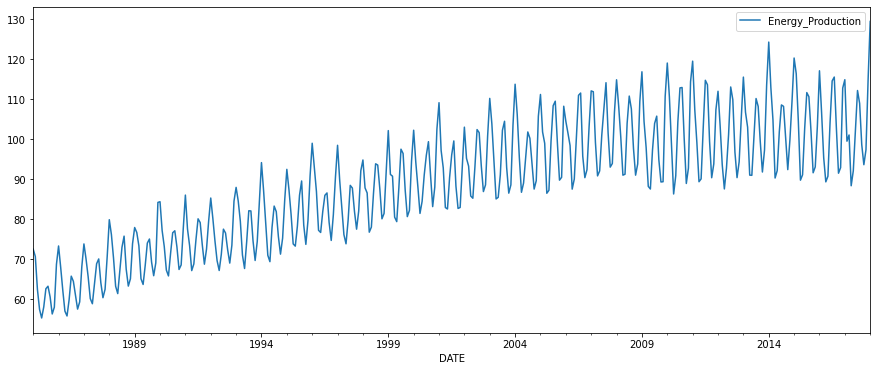

In [29]:
## Visualiza los datos de produccion de energia. ¿Que conclusiones sacas?
df.plot(figsize=(15,6))
plt.show()

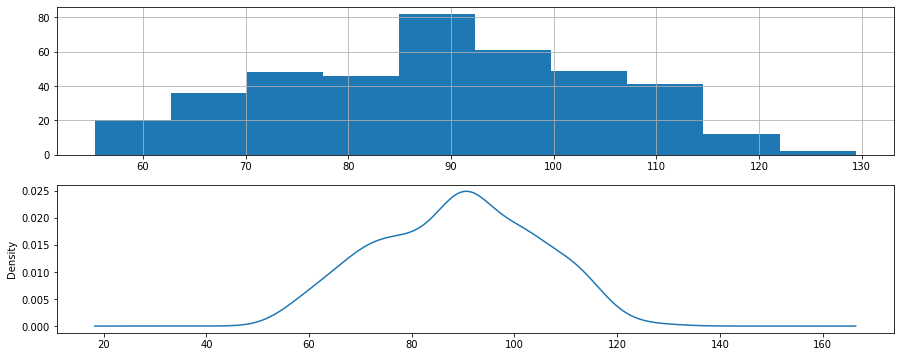

In [30]:
## Genera un KDE plot para analizar la distribucion de los datos. ¿Que distribucion tiene?
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
df.Energy_Production.hist()
pyplot.subplot(212)
df.Energy_Production.plot(kind='kde')
pyplot.show()

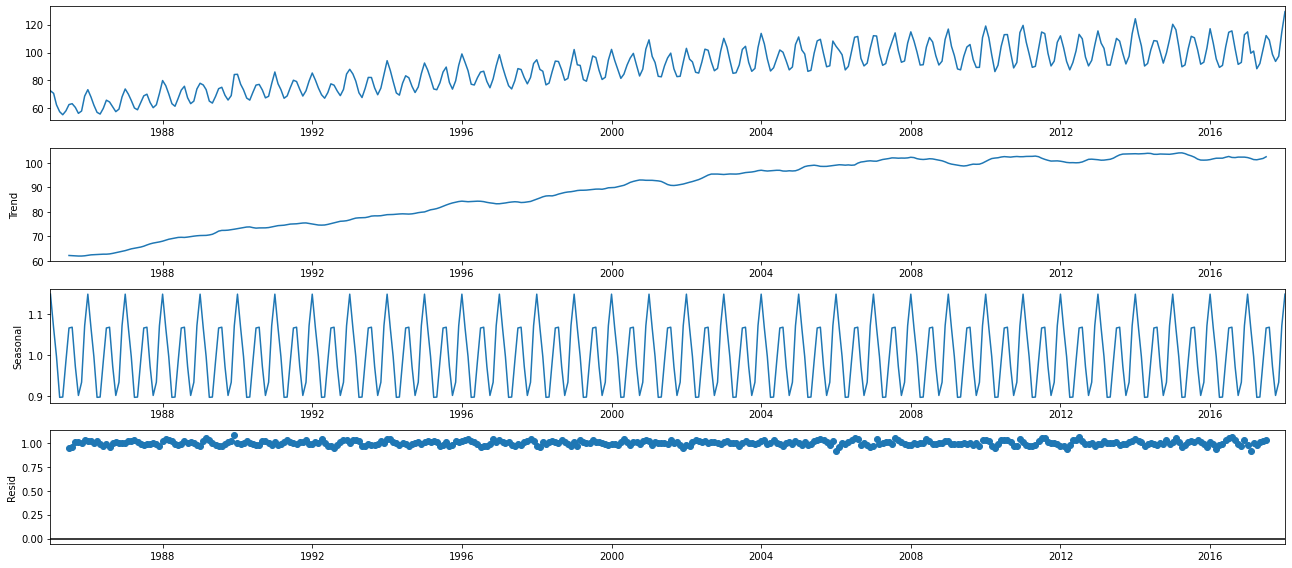

In [31]:
## Descompon la serie temporal en sus componentes
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='multiplicative')
fig = decomposition.plot()
plt.show()

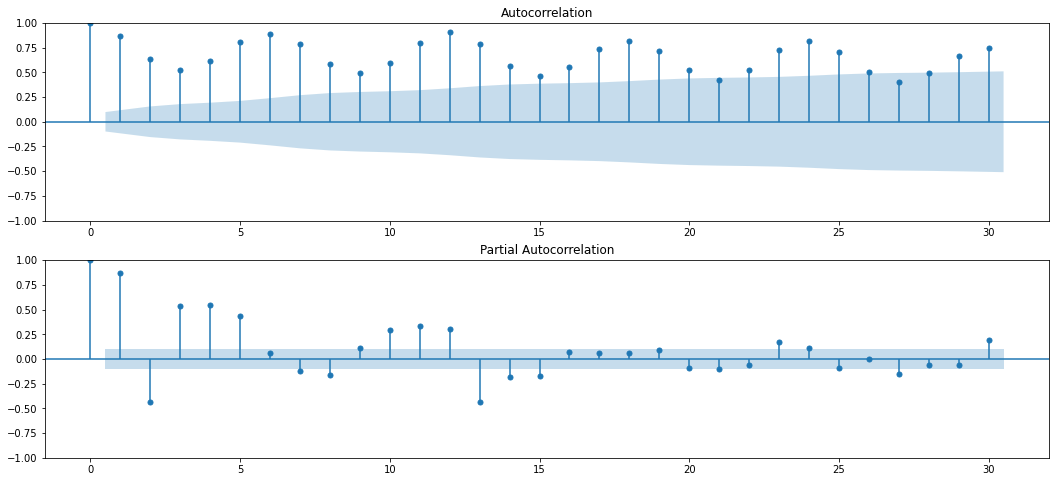

In [32]:
## ¿Los datos son estacionarios?
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(df.Energy_Production, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(df.Energy_Production, ax=pyplot.gca(), lags = 30)
pyplot.show()

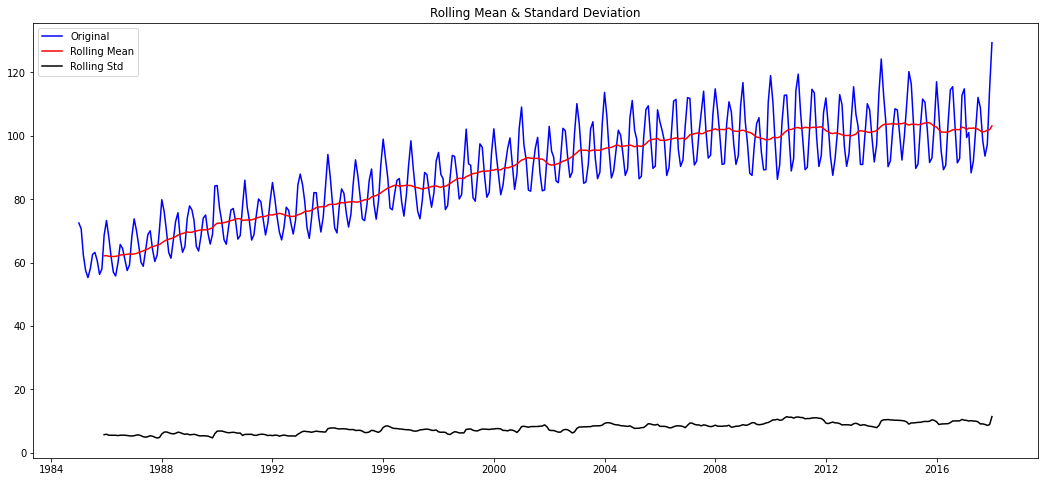

In [33]:
#Determing rolling statistics
rolmean = df.rolling(12).mean()
rolstd = df.rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [34]:
from statsmodels.tsa.stattools import adfuller
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df.Energy_Production, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


En el gráfico de arriba podemos ver claramente el componente estacional de los datos, y también podemos ver la tendencia ascendente separada de los datos.

# Parte II

# Predicción de Series Temporales

## Autoregresión (AR)

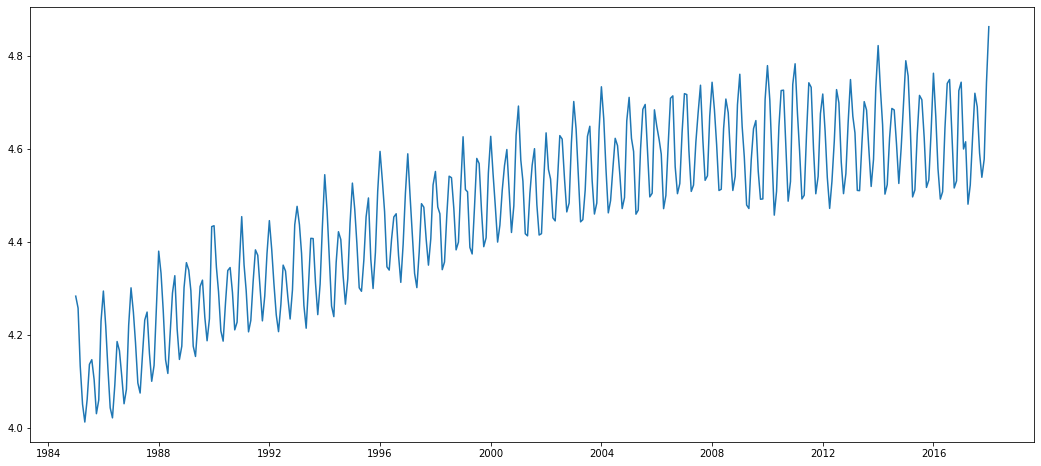

In [35]:
## Hacer que los datos sean estacionales
ts_log = np.log(df)
plt.plot(ts_log)

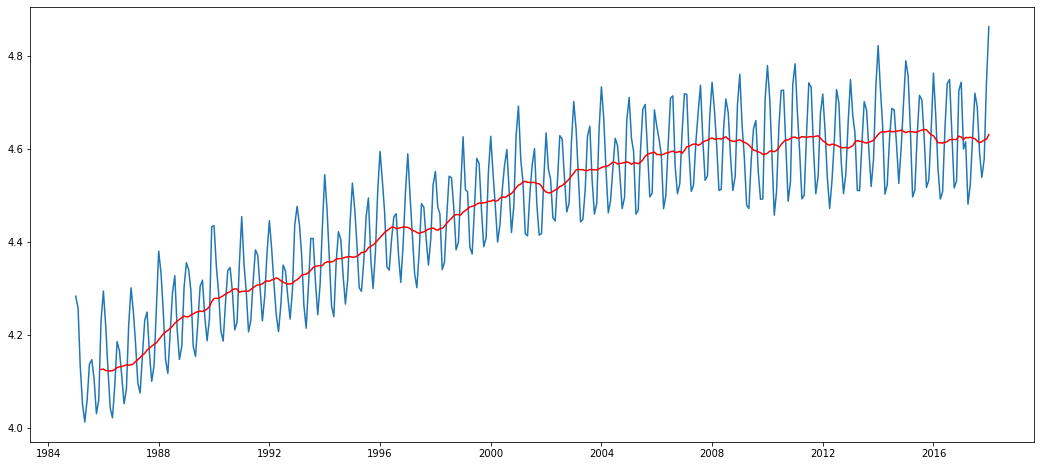

In [36]:
# Media móvil 
moving_avg = ts_log.rolling(12).mean()

plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [37]:
ts_log_moving_avg_diff = ts_log.Energy_Production - moving_avg.Energy_Production
ts_log_moving_avg_diff.head(12)

DATE
1985-01-01         NaN
1985-02-01         NaN
1985-03-01         NaN
1985-04-01         NaN
1985-05-01         NaN
1985-06-01         NaN
1985-07-01         NaN
1985-08-01         NaN
1985-09-01         NaN
1985-10-01         NaN
1985-11-01         NaN
1985-12-01    0.103961
Name: Energy_Production, dtype: float64

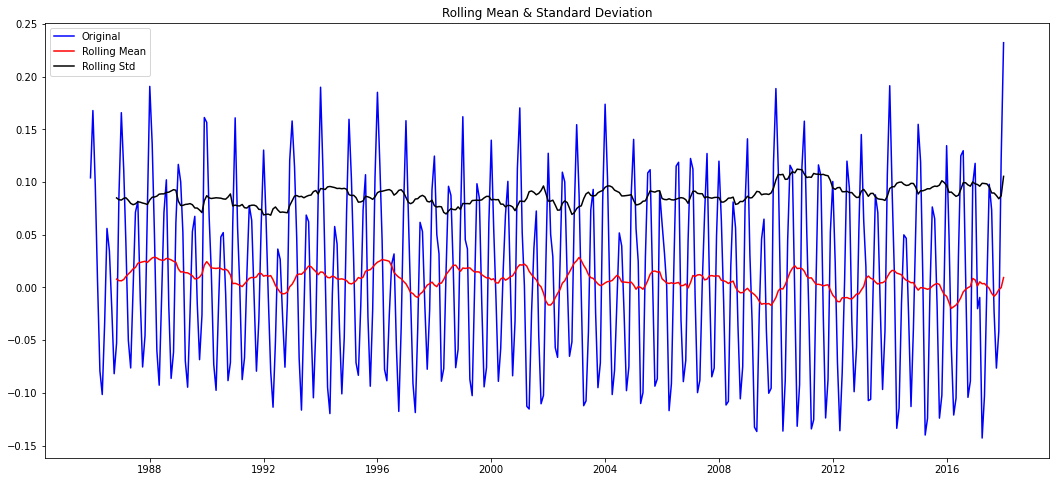

Results of Dickey-Fuller Test:
Test Statistic                  -5.211586
p-value                          0.000008
#Lags Used                      15.000000
Number of Observations Used    370.000000
Critical Value (1%)             -3.448148
Critical Value (5%)             -2.869383
Critical Value (10%)            -2.570948
dtype: float64


In [38]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

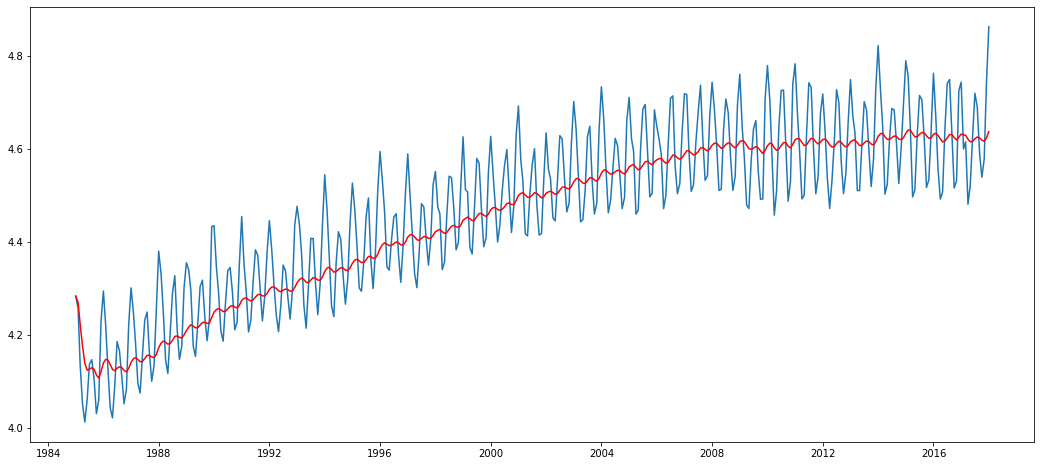

In [39]:
# Media móvil ponderada exponencialmente
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

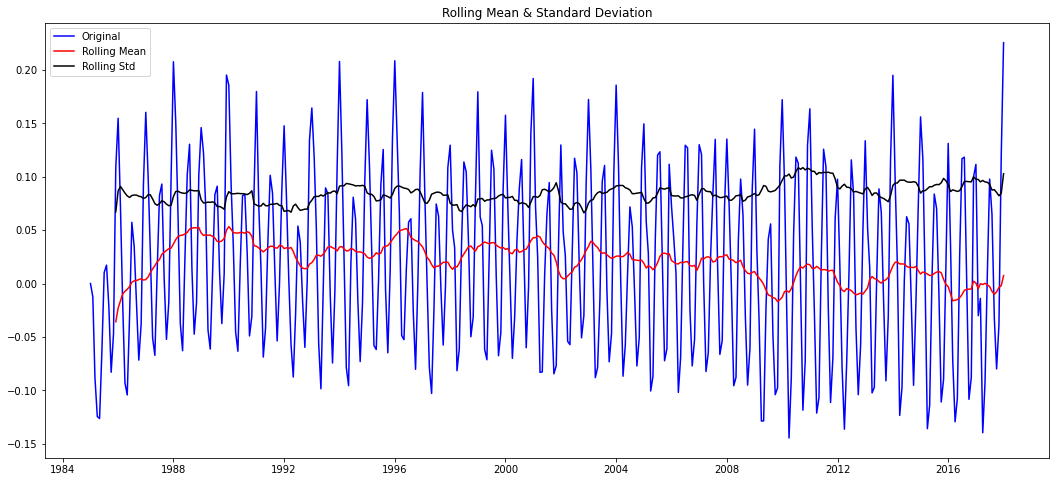

Results of Dickey-Fuller Test:
Test Statistic                  -3.251531
p-value                          0.017189
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [40]:
ts_log_ewma_diff = ts_log.Energy_Production - expwighted_avg.Energy_Production
test_stationarity(ts_log_ewma_diff)

conclusión: el mejor modelo es el con media móvil 

In [104]:
## Entrena un modelo de auto-regresion (AR)
from statsmodels.tsa.ar_model import AutoReg
from random import random

In [105]:
# fit model
model = AutoReg(ts_log_moving_avg_diff, lags=15)
model_fit = model.fit()

In [106]:
y, predicted_value = ts_log_moving_avg_diff, model_fit.fittedvalues

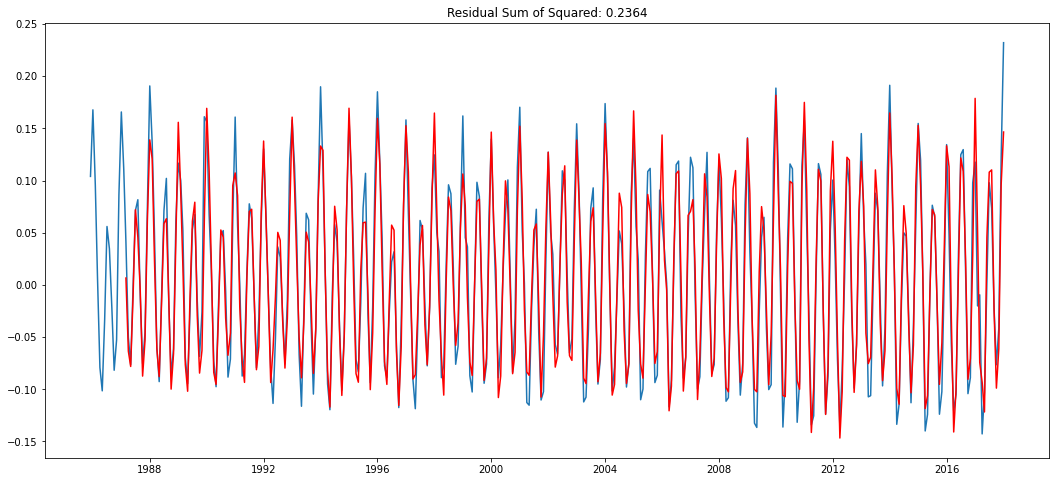

In [107]:
## Genera un grafico donde se pueda visualizar el ajuste del modelo, con los datos originales y los datos obtenidos del modelo
plt.plot(ts_log_moving_avg_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('Residual Sum of Squared: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_moving_avg_diff)**2))
plt.show()

In [108]:
from sklearn.metrics import r2_score

print(f"r2 score: {r2_score(ts_log_moving_avg_diff[15:],model_fit.fittedvalues)}")


r2 score: 0.9114809698882261


Ahora entrenar modelo sin transformar datos

In [109]:
# fit model
model = AutoReg(df.Energy_Production, lags=15)
model_fit = model.fit()

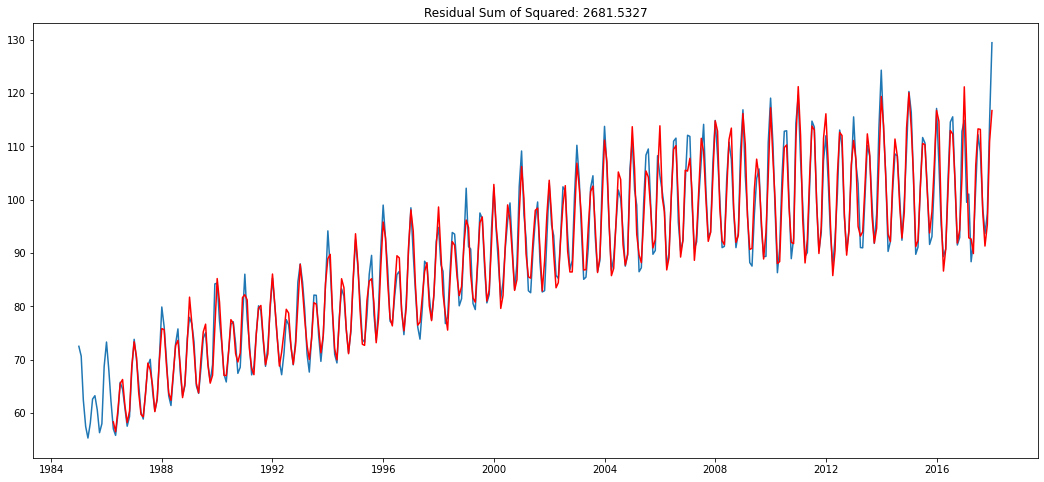

In [110]:
## Genera un grafico donde se pueda visualizar el ajuste del modelo, con los datos originales y los datos obtenidos del modelo
plt.plot(df.Energy_Production)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('Residual Sum of Squared: %.4f'% np.nansum((model_fit.fittedvalues-df.Energy_Production)**2))
plt.show()

In [111]:
print(f"r2 score: {r2_score(df.Energy_Production[15:],model_fit.fittedvalues)}")


r2 score: 0.9677277227221449


# Parte III

## Media móvil (MA)

In [144]:
## Entrena un modelo de de Media Movil(MA)
model_MA = sm.tsa.arima.ARIMA(df.Energy_Production, order=(0, 1,1))
model_fit = model_MA.fit()

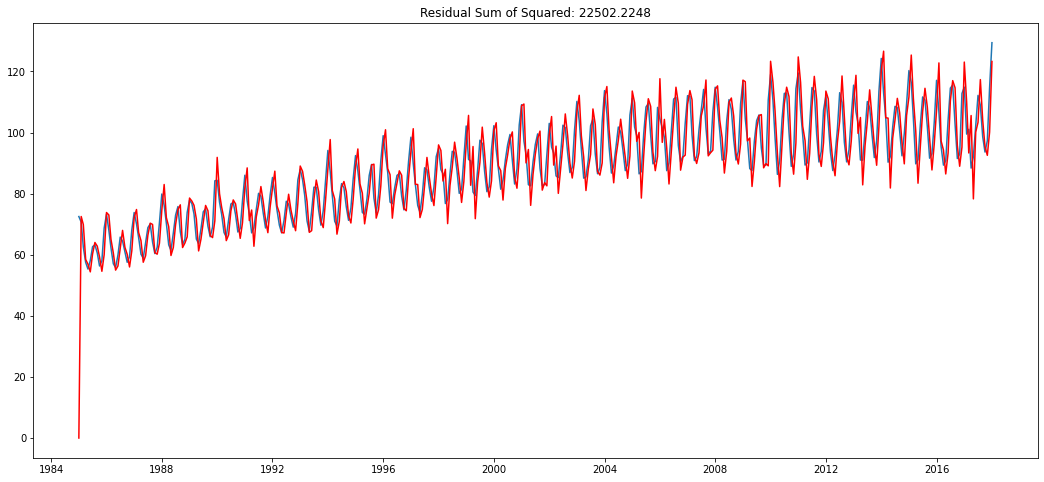

In [145]:
## Genera un grafico donde se pueda visualizar el ajuste del modelo, con los datos originales y los datos obtenidos del modelo
plt.plot(df.Energy_Production)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('Residual Sum of Squared: %.4f'% np.nansum((model_fit.fittedvalues-df.Energy_Production)**2))
plt.show()

In [146]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Energy_Production   No. Observations:                  397
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1309.275
Date:                Sun, 01 May 2022   AIC                           2622.550
Time:                        00:07:33   BIC                           2630.513
Sample:                    01-01-1985   HQIC                          2625.705
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5854      0.041     14.280      0.000       0.505       0.666
sigma2        43.5349      3.315     13.131      0.000      37.037      50.033
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 1.22
Prob(Q):                              0.50   Prob(JB):                         0.54
Heteroskedasticity (H):               2.96   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [147]:
print(f"r2 score: {r2_score(df.Energy_Production[1:],model_fit.fittedvalues[1:])}")


r2 score: 0.8155577402297224


In [150]:
## Entrena un modelo de de Media Movil(MA)
model_MA = sm.tsa.arima.ARIMA(ts_log_moving_avg_diff, order=(0, 1,1))
model_fit = model_MA.fit()

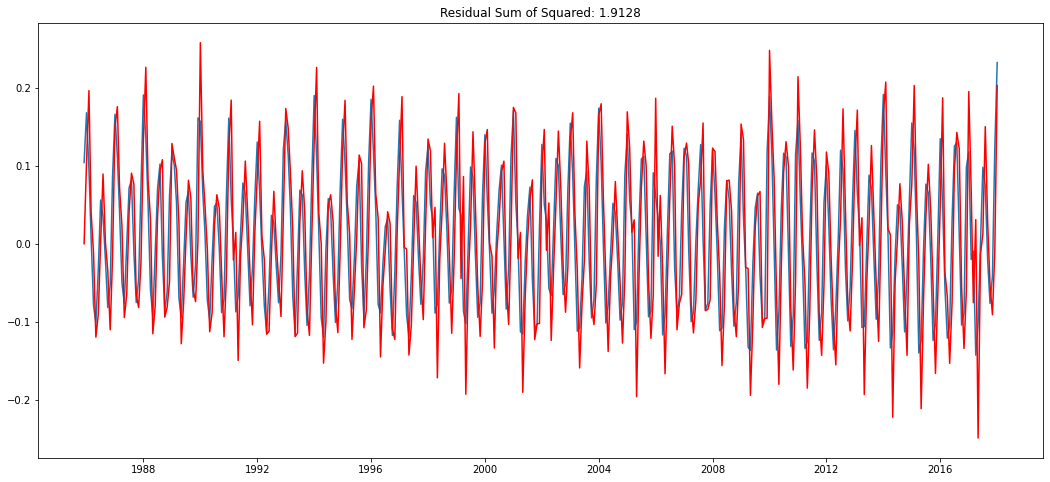

In [151]:
## Genera un grafico donde se pueda visualizar el ajuste del modelo, con los datos originales y los datos obtenidos del modelo
plt.plot(ts_log_moving_avg_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('Residual Sum of Squared: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_moving_avg_diff)**2))
plt.show()

In [152]:
print(f"r2 score: {r2_score(ts_log_moving_avg_diff,model_fit.fittedvalues)}")


r2 score: 0.31474007401776605


In [10]:
## Obten las metricas de evaluacion del modelo con la funcion evaluate_forecast


## Media móvil autorregresiva (ARMA)

In [153]:

#rom statsmodels.tsa.arima_model import ARMA
from random import random

## Entrena un modelo de ARMA con un order de (2,1)
y = df.Energy_Production
model_MA = sm.tsa.arima.ARIMA(df.Energy_Production, order=(2, 1,0))
model_fit = model.fit()

In [154]:
##Obten el resumen del modelo
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:      Energy_Production   No. Observations:                  397
Model:                    AutoReg(15)   Log Likelihood                -914.241
Method:               Conditional MLE   S.D. of innovations              2.649
Date:                Sun, 01 May 2022   AIC                           1862.481
Time:                        00:10:21   BIC                           1929.553
Sample:                    04-01-1986   HQIC                          1889.090
                         - 01-01-2018                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.4876      1.005      2.474      0.013       0.517       4.458
Energy_Production.L1      0.5998      0.052     11.434      0.000       0.497       0.703
Energy_Production.L2     -0.1373      0.061     -2.260      0.024      -0.256      -0.018
Energy_Production.L3      0.1186      0.059      2.023      0.043       0.004       0.233
Energy_Production.L4     -0.0252      0.051     -0.496      0.620      -0.125       0.074
Energy_Production.L5      0.0705      0.050      1.408      0.159      -0.028       0.169
Energy_Production.L6      0.0208      0.050      0.414      0.679      -0.078       0.119
Energy_Production.L7      0.0563      0.050      1.124      0.261      -0.042       0.155
Energy_Production.L8     -0.0635      0.050     -1.264      0.206      -0.162       0.035
Energy_Production.L9     -0.0530      0.050     -1.055      0.291      -0.152       0.045
Energy_Production.L10     0.0735      0.050      1.457      0.145      -0.025       0.172
Energy_Production.L11     0.0855      0.051      1.666      0.096      -0.015       0.186
Energy_Production.L12     0.6257      0.053     11.763      0.000       0.521       0.730
Energy_Production.L13    -0.3268      0.062     -5.275      0.000      -0.448      -0.205
Energy_Production.L14     0.0668      0.064      1.043      0.297      -0.059       0.192
Energy_Production.L15    -0.1338      0.054     -2.474      0.013      -0.240      -0.028
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0491           -0.0000j            1.0491           -0.5000
AR.2            -0.8991           -0.5209j            1.0391           -0.4164
AR.3            -0.8991           +0.5209j            1.0391            0.4164
AR.4            -0.5383           -0.9200j            1.0659           -0.3343
AR.5            -0.5383           +0.9200j            1.0659            0.3343
AR.6            -0.0104           -1.0573j            1.0574           -0.2516
AR.7            -0.0104           +1.0573j            1.0574            0.2516
AR.8             0.4992           -0.8660j            0.9996           -0.1668
AR.9             0.4992           +0.8660j            0.9996            0.1668
AR.10            0.8821           -0.5149j            1.0214           -0.0841
AR.11            0.8821           +0.5149j            1.0214            0.0841
AR.12            1.0050           -0.0000j            1.0050           -0.0000
AR.13            1.4111           -0.0000j            1.4111           -0.0000
AR.14           -0.3674           -1.8379j            1.8742           -0.2814
AR.15           -0.3674           +1.8379j            1.8742            0.2814
------------------------------

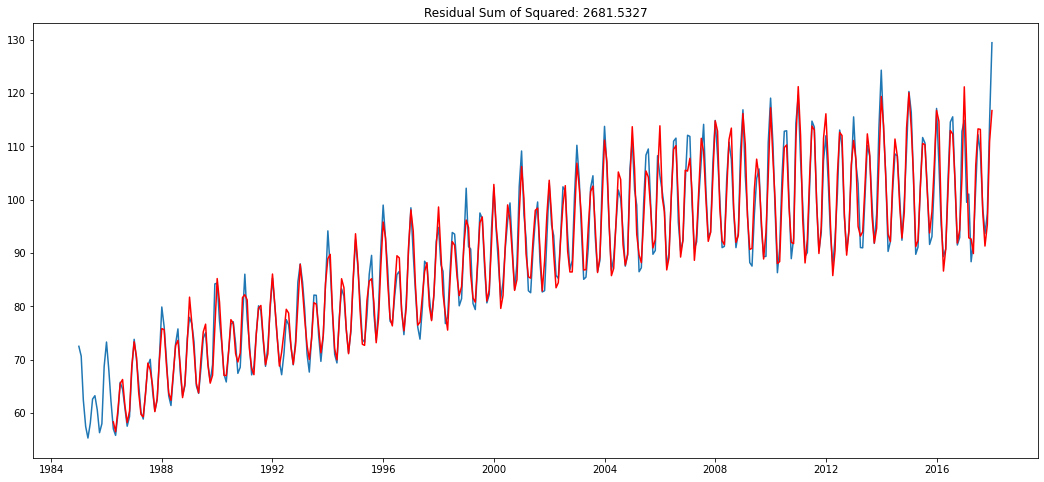

In [155]:
## Visualiza el ajuste del modelo
## Genera un grafico donde se pueda visualizar el ajuste del modelo, con los datos originales y los datos obtenidos del modelo
plt.plot(df.Energy_Production)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('Residual Sum of Squared: %.4f'% np.nansum((model_fit.fittedvalues-df.Energy_Production)**2))
plt.show()

In [157]:
## Calucla sis metricas de evaluacion ¿Crees que se ajusta bien?
predictions_ARMA = pd.Series(model_fit.fittedvalues, copy=True)
evaluate_forecast(df.Energy_Production[15:], predictions_ARMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.967728,1.968478,1.593467,7.019719,0.000741,2.118598,2.649475


# Parte IV

## Media móvil integrada autorregresiva (ARIMA)


In [449]:
## Entrena un modelo de ARIMA


In [160]:
y = df.Energy_Production
y

DATE
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
                ...   
2017-09-01     98.6154
2017-10-01     93.6137
2017-11-01     97.3359
2017-12-01    114.7212
2018-01-01    129.4048
Name: Energy_Production, Length: 397, dtype: float64

<AxesSubplot:xlabel='DATE'>

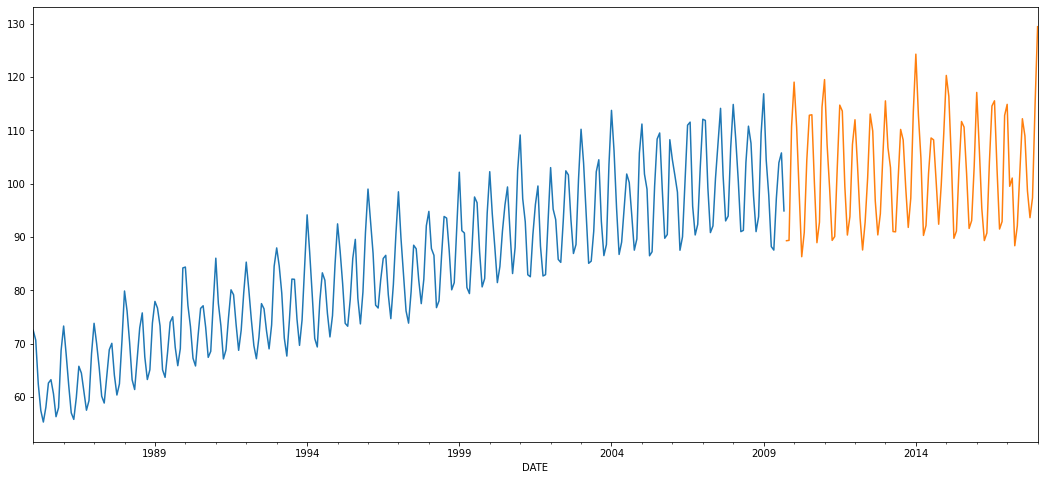

In [163]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train.plot()
valid.plot()

In [169]:
model = sm.tsa.arima.ARIMA(y, order=(1, 2,2))
model_fit = model.fit()

In [171]:
print(model_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0769      0.114      0.674      0.500      -0.147       0.301
ma.L1         -0.4562     23.040     -0.020      0.984     -45.613      44.701
ma.L2         -0.5438     12.484     -0.044      0.965     -25.012      23.925
sigma2        43.5255   1001.041      0.043      0.965   -1918.478    2005.529


In [175]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Energy_Production   No. Observations:                  397
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1308.428
Date:                Sun, 01 May 2022   AIC                           2624.856
Time:                        02:00:46   BIC                           2640.772
Sample:                    01-01-1985   HQIC                          2631.162
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0769      0.114      0.674      0.500      -0.147       0.301
ma.L1         -0.4562     23.040     -0.020      0.984     -45.613      44.701
ma.L2         -0.5438     12.484     -0.044      0.965     -25.012      23.925
sigma2        43.5255   1001.041      0.043      0.965   -1918.478    2005.529
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 1.83
Prob(Q):                              0.75   Prob(JB):                         0.40
Heteroskedasticity (H):               2.90   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [173]:
start_index = valid.index.min()
end_index = valid.index.max()
#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [174]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 8.230156174693953, MSE:67.735470659853


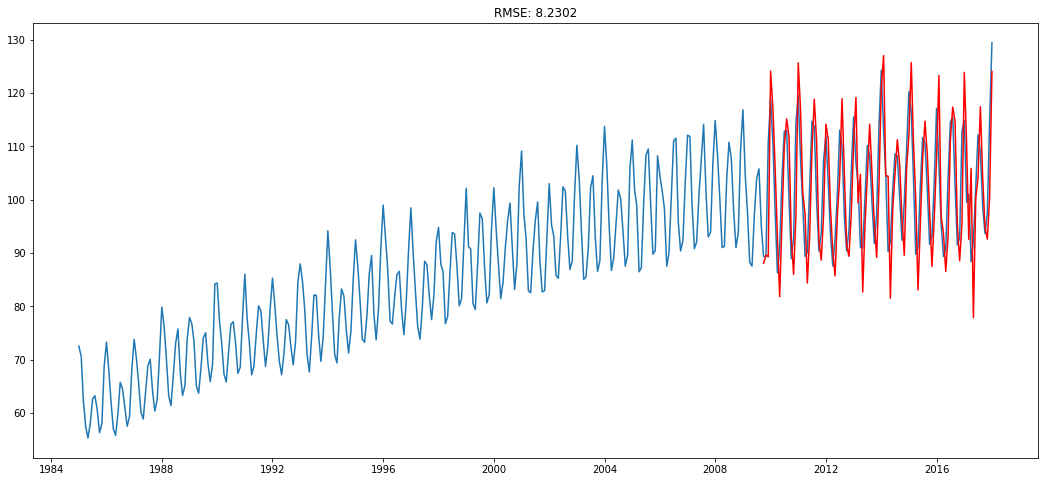

In [177]:
plt.plot(y)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

In [179]:
evaluate_forecast(y[start_index:end_index],predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.307635,7.092214,6.338134,67.735471,0.006429,6.942884,8.230156


In [454]:
r2_score(y[start_index:end_index], forecast)

-90.3167809550969

# Auto ARIMA

In [182]:
## Entrena un modelo con auto_ARIMA

#building the model
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1991.592, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1950.974, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1901.222, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1989.627, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1902.970, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1899.233, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1900.980, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1835.789, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1811.952, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1785.911, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1785.816, T

ARIMA(order=(1, 1, 5), scoring_args={}, suppress_warnings=True)

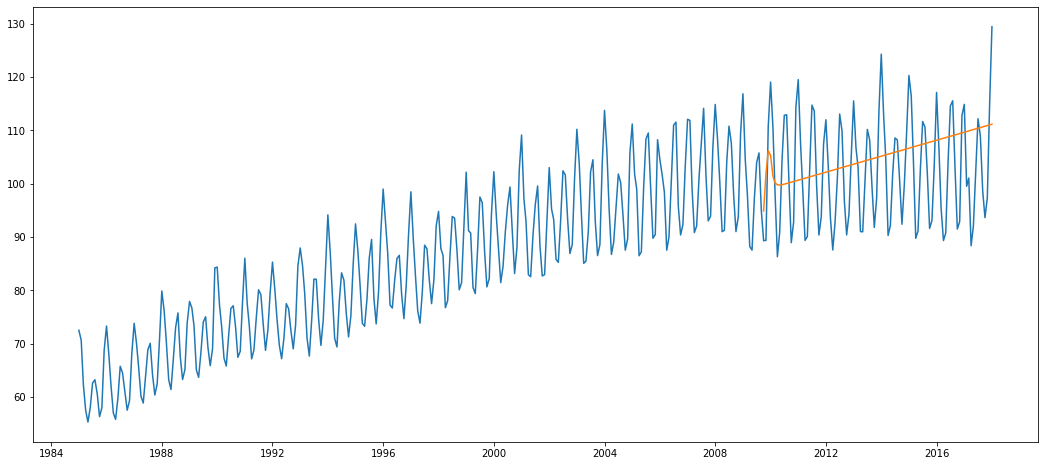

In [185]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Energy_Consumption'])

#plot the predictions for validation set
plt.plot(y, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [186]:
evaluate_forecast(valid, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-0.10352,8.871234,8.63732,107.959579,0.01014,NaN,10.39036


In [14]:
## Visualiza que tal se ajusta el modelo de auto-ARIMA

In [15]:
## Obten sus métricas de rendimiento ¿que tal se ajusta?

# Parte V

# AUTO-SARIMA

In [187]:
## Entrena un modelo con auto_SARIMA
model = auto_arima(train, trace=True, error_action='ignore', 
                   suppress_warnings=True, seasonal=True, m=6, stepwise=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=1991.592, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=1759.640, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=1867.734, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=1989.627, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=1950.974, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[6] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(1,0,1)[6] intercept   : AIC=1539.857, Time=0.40 sec
 ARIMA(1,1,0)(0,0,1)[6] intercept   : AIC=1890.329, Time=0.13 sec
 ARIMA(1,1,0)(2,0,1)[6] intercept   : AIC=1467.217, Time=0.82 sec
 ARIMA(1,1,0)(2,0,2)[6] intercept   : AIC=1380.407, Time=1.12 sec
 ARIMA(1,1,0)(1,0,2)[6] intercept   : AIC=1500.823, Time=0.74 sec
 ARIMA(0,1,0)(2,0,2)[6] intercept   : AIC=1392.627, Time=0.76 sec
 ARIMA(2,1,0)(2,0,2)[6] intercept   : AIC=1360.582, Time=1.45 sec
 ARIMA(2,1,0)(1,0,2)[6] intercept   : AIC=1

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 0, 2, 6),
      suppress_warnings=True, with_intercept=False)

In [188]:
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred,index = valid.index,columns=['Prediction'])

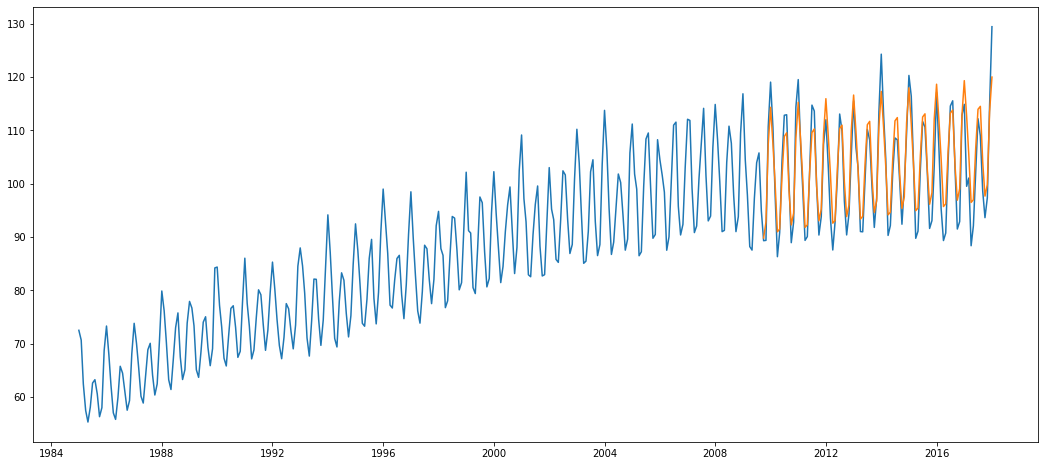

In [189]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [190]:
evaluate_forecast(y[start_index:end_index], forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.833258,3.321922,2.905644,16.312732,0.001515,NaN,4.038902


In [17]:
## ¿Que tal se ajusta el modelo?

In [191]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [192]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:3475.4613560711014
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:3090.3282010857947
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1824.656723835096
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:1639.368431440446
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1833.0969655744082
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:1609.684906963429
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:1491.3389386534236
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:1468.7433456371916
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:3079.3571937076126
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:2722.226520364762
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:1696.0982621774556
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:1503.8916383254896
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1845.0773766615448
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:1722.934027157788
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:1379.8958684766117
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:1364.9111458338634
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:1983.8407805018055
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:1865.9827567384596
ARIMA(0, 1, 0)x

In [193]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

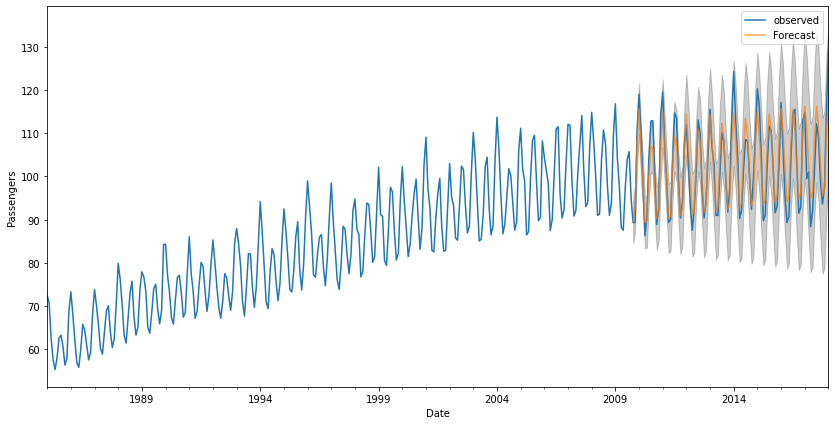

In [194]:
pred_ci = pred.conf_int()
ax = y['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

In [198]:
y_forecasted = pred.predicted_mean.values
y_truth = y[start_index:end_index].values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 15.6


In [199]:
evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.840506,3.131974,2.8251,15.60357,0.001361,3.010577,3.950135


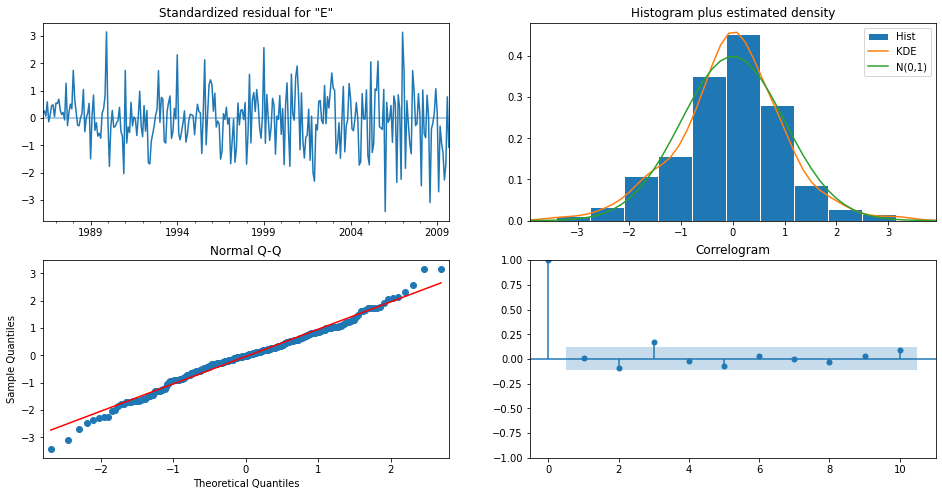

In [200]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()